In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

#### 1. Data Overview

In [3]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [4]:
user = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [5]:
print(engagement.shape)
engagement.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [7]:
engagement.tail()

,time_stamp,user_id,visited
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1
207916,2014-01-26 08:57:12,12000,1


In [8]:
engagement_count = engagement['user_id'].value_counts()

<Axes: >

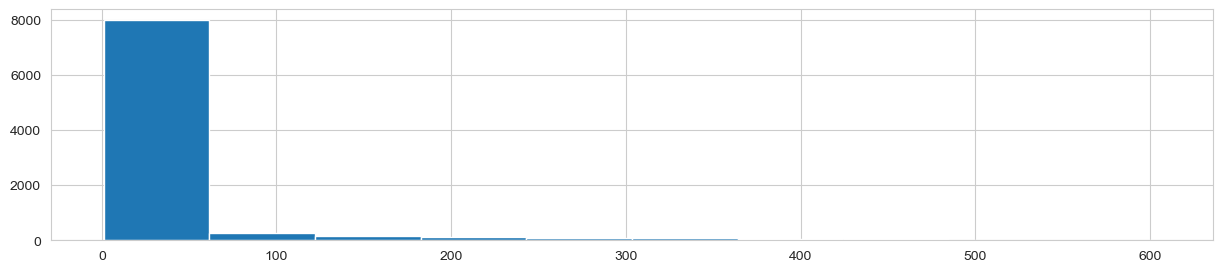

In [9]:
engagement_count.hist(figsize = (15,3))

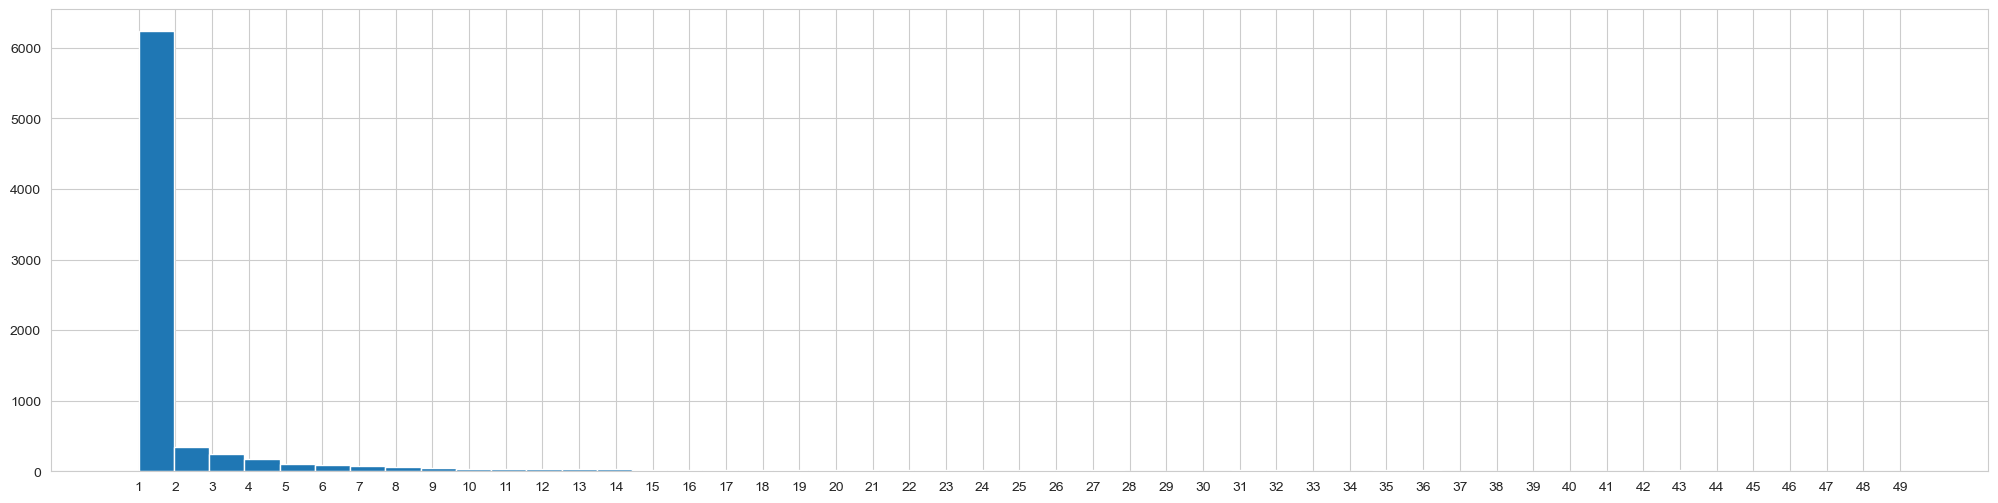

In [10]:
engagement_count[lambda x: x < 50].hist(figsize = (25,6),bins = 50)
plt.xticks(range(1, 50))
plt.show()

In [11]:
print(str(round((len(engagement_count[engagement_count < 3])/len(engagement_count)), 2)*100) 
      + '% users in record logged in less than 3 times. ')
print(str(round((len(engagement_count[engagement_count >= 3])/len(engagement_count)), 2)*100) 
      + '% users in record logged for 3 times or more. ')

75.0% users in record logged in less than 3 times. 
25.0% users in record logged for 3 times or more. 


In [12]:
print(user.shape)
user.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [13]:
user.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [14]:
print('unique object id: ' + str(len(user['object_id'].unique())))
print('unique name: ' + str(len(user['name'].unique())))

unique object id: 12000
unique name: 11355


#### 2. Transformation

In [15]:
# Filter out users that logged in for less than three times
engagement_new = engagement[engagement['user_id'].isin(engagement_count.index[engagement_count >= 3])]

In [16]:
engagement_new.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [17]:
engagement_new['time_stamp'] = pd.to_datetime(engagement_new['time_stamp'])

In [18]:
engagement_new['Date'] = engagement_new['time_stamp'].dt.date
engagement_new['Time'] = engagement_new['time_stamp'].dt.time

In [19]:
engagement_new = engagement_new.drop_duplicates(subset=['Date', 'user_id'])

In [20]:
engagement_new['7_days_after'] = engagement_new['Date'] + pd.DateOffset(days=7)

In [21]:
engagement_new = engagement_new.sort_values(by = ['user_id', 'Date'])

In [22]:
engagement_new['thirdLog'] = engagement_new.groupby('user_id')['Date'].apply(lambda x: x.shift(-2))
engagement_new['thirdLog'] = pd.to_datetime(engagement_new['thirdLog'])

In [23]:
engagement_new['adopted'] = engagement_new.apply(lambda row: 'Yes' if row['7_days_after'] > row['thirdLog'] else 'No', axis = 1)

In [24]:
engagement_new.head(20)

,time_stamp,user_id,visited,Date,Time,7_days_after,thirdLog,adopted
1,2013-11-15 03:45:04,2,1,2013-11-15,03:45:04,2013-11-22,2013-12-09,No
2,2013-11-29 03:45:04,2,1,2013-11-29,03:45:04,2013-12-06,2013-12-25,No
3,2013-12-09 03:45:04,2,1,2013-12-09,03:45:04,2013-12-16,2013-12-31,No
4,2013-12-25 03:45:04,2,1,2013-12-25,03:45:04,2014-01-01,2014-01-08,No
5,2013-12-31 03:45:04,2,1,2013-12-31,03:45:04,2014-01-07,2014-02-03,No
6,2014-01-08 03:45:04,2,1,2014-01-08,03:45:04,2014-01-15,2014-02-08,No
7,2014-02-03 03:45:04,2,1,2014-02-03,03:45:04,2014-02-10,2014-02-09,Yes
8,2014-02-08 03:45:04,2,1,2014-02-08,03:45:04,2014-02-15,2014-02-13,Yes
9,2014-02-09 03:45:04,2,1,2014-02-09,03:45:04,2014-02-16,2014-02-16,No
10,2014-02-13 03:45:04,2,1,2014-02-13,03:45:04,2014-02-20,2014-03-09,No


In [221]:
engagement_adopted = engagement_new[engagement_new['adopted'] == 'Yes']

In [232]:
user_new = user.copy()

In [233]:
user_new['adopted'] = user_new['object_id'].apply(lambda x: 'Yes' if x in(engagement_adopted['user_id'].values) else 'No')

In [234]:
user_new['usage'] = user_new['object_id'].apply(lambda x : engagement_count[x] if x in engagement_count.index else 0)

In [235]:
user_new.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,usage
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,No,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,Yes,14
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,No,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,No,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,No,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,No,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,No,1
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,No,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,No,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,Yes,284


In [236]:
user_new.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                        object
usage                           int64
dtype: object

In [237]:
user_new['adopted'].value_counts()

No     10398
Yes     1602
Name: adopted, dtype: int64

In [238]:
user_new['email'] = user_new['email'].apply(lambda x: x.split('@')[-1])

In [239]:
user_new['email'] = user_new['email'].apply(lambda x: x.split('.')[0])

In [240]:
user_new['creation_time'] = pd.to_datetime(user_new['creation_time'])

In [241]:
user_new['creation_time'] = user_new['creation_time'].apply(lambda x: x.strftime("%Y-%m"))
user_new['creation_time'] = pd.to_datetime(user_new['creation_time'])
user_new['creation_time'] = user_new['creation_time'].apply(lambda x: x.timestamp())

In [242]:
user_new['creation_time'].value_counts()

1.398902e+09    976
1.396310e+09    730
1.393632e+09    712
1.388534e+09    582
1.383264e+09    530
1.391213e+09    527
1.380586e+09    523
1.385856e+09    518
1.377994e+09    492
1.375315e+09    487
1.362096e+09    465
1.372637e+09    465
1.367366e+09    463
1.356998e+09    447
1.370045e+09    440
1.364774e+09    439
1.354320e+09    412
1.346458e+09    409
1.359677e+09    407
1.351728e+09    406
1.338509e+09    401
1.349050e+09    401
1.341101e+09    387
1.343779e+09    365
1.335830e+09     16
Name: creation_time, dtype: int64

In [243]:
user_new['org_id'].nunique()

417

In [244]:
user_new['invited_by_user_id'].nunique()

2564

In [245]:
user_new['email'].nunique()

1184

In [246]:
user_new['email'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
oqpze            2
qgjbc            2
dqwln            2
mumdc            2
xybhi            2
xvnbr            2
luque            2
ydtmd            1
upqhn            1
ceqro            1
xagdy            1
gctmd            1
kmgtc            1
mngrr            1
rzxro            1
kbaxq            1
zwmry            1
orsoq            1
rsmif            1
eznoh            1
rnlqw            1
ieupn            1
vkjsm            1
nhtyl            1
fboqn            1
yyucc            1
lurdm            1
eqtvz            1
flnib            1
dshis            1
yhnuj            1
hfbri            1
bfxyd            1
syspy            1
nqnui            1
gzfyg            1
smicl            1
hmlvw            1
lgybi            1
sleif            1
tfsce            1
khhlm            1
lyjyt            1
xnuls            1
itsly            1
qqgix       

In [247]:
common_email = ['gmail','yahoo', 'jourrapide', 'cuvox ', 'gustr', 'hotmail']

In [248]:
user_new['email'] = user_new['email'].apply(lambda x: 'other' if x not in common_email else x)

In [249]:
user_new['org_id'].value_counts()

0      319
1      233
2      201
3      168
4      159
6      138
5      128
9      124
7      119
10     104
8       97
14      87
12      75
11      75
17      74
18      73
16      72
13      72
20      68
15      64
24      63
25      62
28      61
23      60
30      59
22      58
33      57
40      57
21      56
27      55
31      54
19      53
26      53
32      52
29      50
36      50
53      50
45      49
34      48
57      48
41      48
50      48
39      47
35      46
43      46
49      45
59      45
38      45
37      44
54      44
47      43
46      43
88      42
58      42
66      42
52      41
84      40
98      40
42      40
89      40
107     40
90      40
61      40
119     39
64      39
62      39
60      39
76      39
63      38
51      38
69      38
75      38
74      38
95      37
144     37
104     36
71      36
44      36
56      35
86      35
68      35
72      35
70      35
97      35
93      34
80      34
109     34
145     33
48      33
94      32
91      32

In [250]:
user_new.head(50)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,usage
0,1,1.396310e+09,Clausen August,yahoo,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,No,1
1,2,1.383264e+09,Poole Matthew,gustr,ORG_INVITE,1.396238e+09,0,0,1,316.0,Yes,14
2,3,1.362096e+09,Bottrill Mitchell,gustr,ORG_INVITE,1.363735e+09,0,0,94,1525.0,No,1
3,4,1.367366e+09,Clausen Nicklas,yahoo,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,No,1
4,5,1.356998e+09,Raw Grace,yahoo,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,No,1
5,6,1.385856e+09,Cunha Eduardo,yahoo,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,No,1
6,7,1.354320e+09,Sewell Tyler,jourrapide,SIGNUP,1.356010e+09,0,1,37,NaN,No,1
7,8,1.372637e+09,Hamilton Danielle,yahoo,PERSONAL_PROJECTS,NaN,1,1,74,NaN,No,0
8,9,1.383264e+09,Amsel Paul,hotmail,PERSONAL_PROJECTS,NaN,0,0,302,NaN,No,0
9,10,1.356998e+09,Santos Carla,gustr,ORG_INVITE,1.401833e+09,1,1,318,4143.0,Yes,284


In [251]:
cat_col = ['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']
num_col = ['creation_time', 'last_session_creation_time', 'org_id', 'invited_by_user_id', 'usage']

In [252]:
adopted = user_new[user_new['adopted'] == 'Yes']
notadopted = user_new[user_new['adopted'] == 'No']

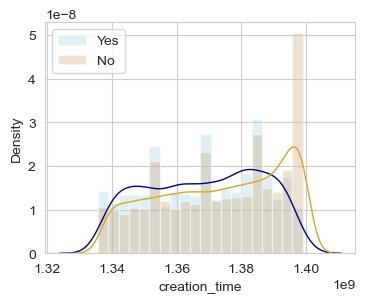

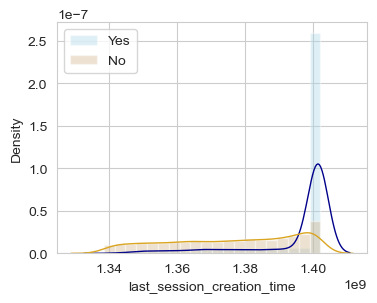

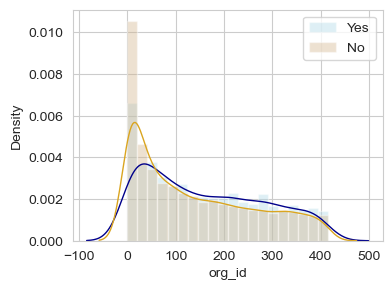

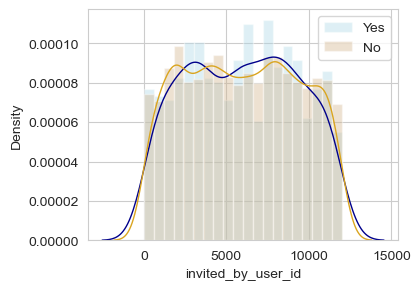

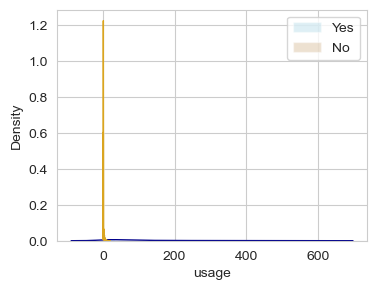

In [253]:
for num in num_col:
    fig, ax = plt.subplots(figsize=(4,3))
    sns.distplot(adopted[num], hist=True, kde=True, 
                 kde_kws={'linewidth':1, 'color': 'darkblue'}, bins=20, color='lightblue', label='Yes')
    sns.distplot(notadopted[num], hist=True, kde=True, 
                 kde_kws={'linewidth':1, 'color': 'goldenrod'}, bins=20, color='tan', label='No')
    plt.legend()
    plt.show()

In [254]:
user_new['usage'].value_counts()

1      6235
0      3177
2       340
3       241
4       181
5       110
6        85
7        68
8        57
9        48
10       34
14       30
12       29
13       29
11       26
22       23
16       20
25       19
17       18
23       18
18       18
20       16
24       15
26       15
21       15
36       13
35       13
15       13
27       13
43       13
19       12
32       12
31       12
78       11
41       11
28       10
44       10
54       10
30        9
48        9
34        9
46        9
29        9
33        9
63        8
56        8
40        8
217       8
57        7
51        7
93        7
146       7
112       7
42        7
79        7
100       7
65        7
50        7
70        7
60        7
49        7
68        6
80        6
59        6
173       6
88        6
160       6
142       6
144       6
94        6
115       6
106       6
85        6
304       6
127       6
64        6
98        6
147       5
229       5
326       5
237       5
137       5
289       5
76  

In [255]:
cat_col = ['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']

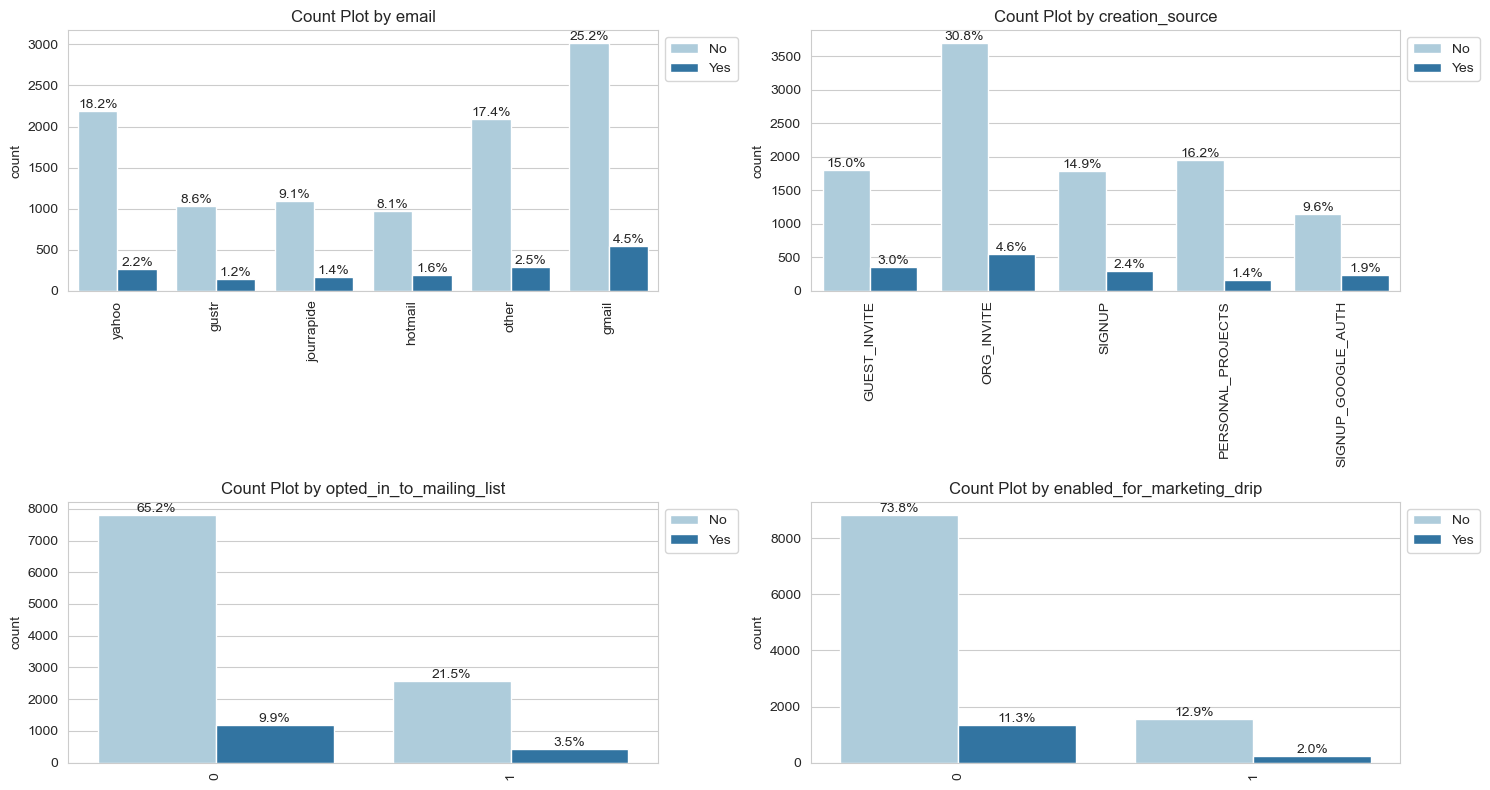

In [256]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.reshape(-1)

for idx, col in enumerate(cat_col):
    sns.countplot(x=col, hue='adopted', data=user_new, palette='Paired', ax=axes[idx])
    axes[idx].set_title('Count Plot by ' + col)
    axes[idx].set_xlabel('')

    # Annotating with percentage
    total_count = len(user_new[col])
    for p in axes[idx].patches:
        height = p.get_height()
        percentage = f"{100 * height / total_count:.1f}%"
        axes[idx].annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                           ha='center', va='bottom')
    axes[idx].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=1)
    axes[idx].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

#### 3. Feature importance

In [257]:
model_df = user_new[['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
                     'usage', 'creation_time', 'adopted', 'org_id']]

In [258]:
model_df['adopted'] = model_df['adopted'].replace({'Yes': 1, 'No': 0}) 
model_df['adopted'] = model_df['adopted'].astype('category')

In [259]:
model_df.dtypes

email                           object
creation_source                 object
opted_in_to_mailing_list         int64
enabled_for_marketing_drip       int64
usage                            int64
creation_time                  float64
adopted                       category
org_id                           int64
dtype: object

In [260]:
model_df.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,usage,creation_time,adopted,org_id
0,yahoo,GUEST_INVITE,1,0,1,1.396310e+09,0,11
1,gustr,ORG_INVITE,0,0,14,1.383264e+09,1,1
2,gustr,ORG_INVITE,0,0,1,1.362096e+09,0,94
3,yahoo,GUEST_INVITE,0,0,1,1.367366e+09,0,1
4,yahoo,GUEST_INVITE,0,0,1,1.356998e+09,0,193


In [261]:
label_encoder = LabelEncoder()
object_cols = ['email', 'creation_source']
for object_col in object_cols:
    model_df[object_col] = label_encoder.fit_transform(model_df[object_col])

In [262]:
def get_importance(df, target):
    '''
    Train a Random Forest Classifier on the given DataFrame `df` to predict the `target` column. 
    Show confusion matrix and plot feature importance     
    
    Args: df(dataframe): dataframe in format that fits Random Forest Classifier
          target(string): dependent variable
    '''
        
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    feature_importances = rf_model.feature_importances_
    features = X_train.columns
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  
    
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sorted_feature_importance_df = sorted_feature_importance_df.reset_index(drop = True)
    print(sorted_feature_importance_df)

    plt.figure(figsize=(6, 4))
    plt.bar(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color = 'lavender')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances in Random Forest (Best Model)')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2602
           1       0.93      0.93      0.93       398

    accuracy                           0.98      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.98      0.98      0.98      3000



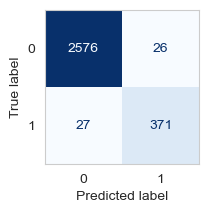

                      Feature  Importance
0                       usage    0.899236
1                      org_id    0.039872
2               creation_time    0.033411
3                       email    0.010913
4             creation_source    0.010645
5    opted_in_to_mailing_list    0.003075
6  enabled_for_marketing_drip    0.002847


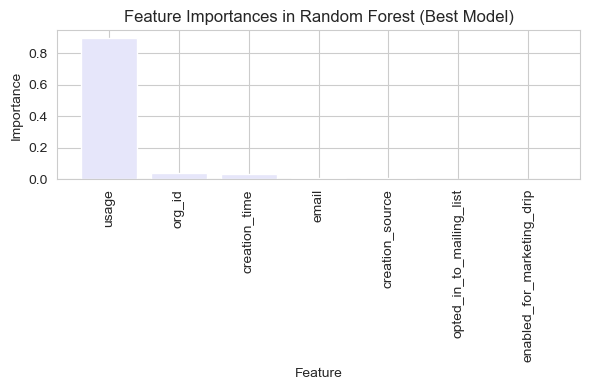

In [263]:
get_importance(model_df, 'adopted')

Usage = 0 or 1 is having a strong correlation with target variable but not really meaningful. Check the model without those customers.

In [318]:
model_df_00 = model_df[(model_df['usage'] != 0) & (model_df['usage'] != 1)]

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       235
           1       0.94      0.95      0.95       412

    accuracy                           0.93       647
   macro avg       0.93      0.92      0.92       647
weighted avg       0.93      0.93      0.93       647



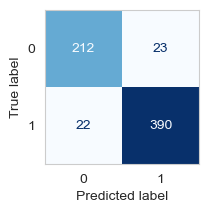

                      Feature  Importance
0                       usage    0.760000
1               creation_time    0.091185
2                      org_id    0.084871
3                       email    0.025020
4             creation_source    0.024128
5    opted_in_to_mailing_list    0.008144
6  enabled_for_marketing_drip    0.006652


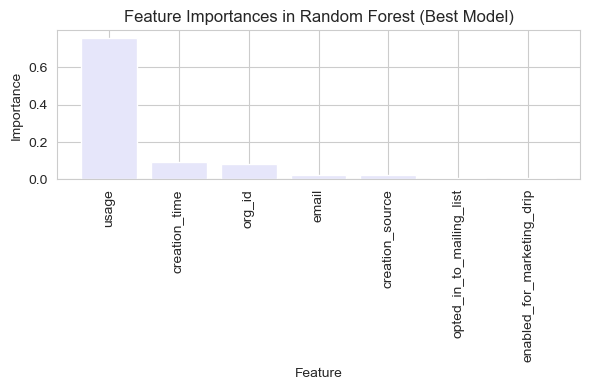

In [319]:
get_importance(model_df_00, 'adopted')

importance of 'usage' still strong

In [320]:
adopted_00 = model_df_00[model_df_00['adopted'] == 1]
notadopted_00 = model_df_00[model_df_00['adopted'] == 0]

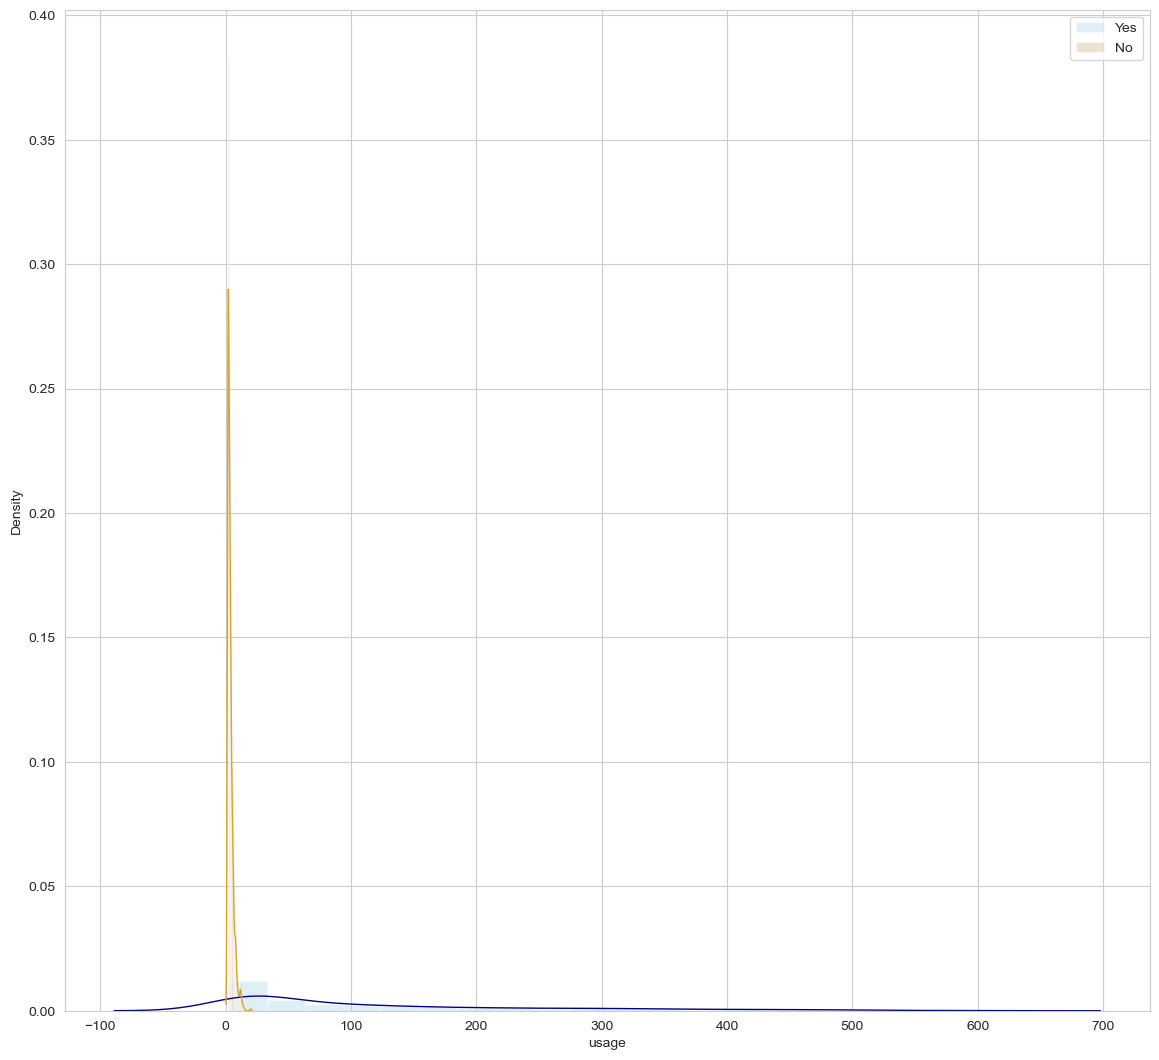

In [322]:
fig, ax = plt.subplots(figsize=(14,13))
sns.distplot(adopted_00['usage'], hist=True, kde=True, 
             kde_kws={'linewidth':1, 'color': 'darkblue'}, bins=20, color='lightblue', label='Yes')
sns.distplot(notadopted_00['usage'], hist=True, kde=True, 
             kde_kws={'linewidth':1, 'color': 'goldenrod'}, bins=20, color='tan', label='No')
plt.legend()
plt.show()

<Axes: >

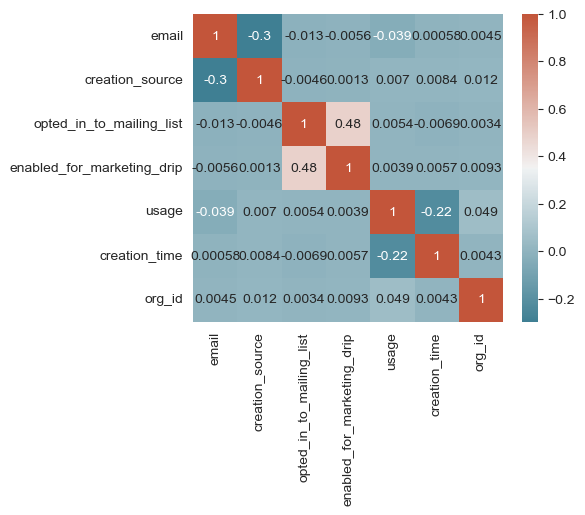

In [264]:
plt.subplots(figsize=(5,4))
sns.heatmap(model_df.corr(),annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [265]:
def stats_logi(df, target):
    '''
    Train a statsmodel logistic regression model on the given DataFrame `df` to predict the specified `target` column. 
    label scaled data with original column names and show model summry.   
    
    Args: df(dataframe): dataframe in format that fits statsmodel logistic regression model
          target(string): dependent variable    
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    for i in range(len(X_train.columns)):
        print('x'+str(i+1)+': '+X_train.columns[i])
        
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test= scaler.transform(X_test)    
    
    log_reg = sm.Logit(y_train,X_train).fit()
    print(log_reg.summary2())

In [266]:
stats_logi(model_df, 'adopted')

x1: email
x2: creation_source
x3: opted_in_to_mailing_list
x4: enabled_for_marketing_drip
x5: usage
x6: creation_time
x7: org_id
Optimization terminated successfully.
         Current function value: 0.067758
         Iterations 13
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.828    
Dependent Variable: adopted          AIC:              1233.6363
Date:               2023-08-03 00:08 BIC:              1283.3712
No. Observations:   9000             Log-Likelihood:   -609.82  
Df Model:           6                LL-Null:          -3541.5  
Df Residuals:       8993             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     13.0000                                     
------------------------------------------------------------------
      Coef.     Std.Err.      z       P>|z|     [0.025     0.975] 
------------------------------------------------------------------
x1    -

Decision: drop feature 'enabled_for_marketing_drip'.

#### 4. Modeling

In [267]:
model_df2 = user_new[['email', 'creation_source', 'opted_in_to_mailing_list', 'creation_time', 'usage', 'org_id', 'adopted']]

In [268]:
model_df2.head()

,email,creation_source,opted_in_to_mailing_list,creation_time,usage,org_id,adopted
0,yahoo,GUEST_INVITE,1,1.396310e+09,1,11,No
1,gustr,ORG_INVITE,0,1.383264e+09,14,1,Yes
2,gustr,ORG_INVITE,0,1.362096e+09,1,94,No
3,yahoo,GUEST_INVITE,0,1.367366e+09,1,1,No
4,yahoo,GUEST_INVITE,0,1.356998e+09,1,193,No


In [269]:
model_df2['adopted'] = model_df2['adopted'].replace({'Yes': 1, 'No': 0}) 
model_df2['adopted'] = model_df2['adopted'].astype('category')

In [270]:
dummy_cols = ['email', 'creation_source']

In [271]:
def get_dummy(df, dummy_cols):
    '''
    Conduct one-hot encoding on specified columns.
    Arg: df(dataframe): dataframe 
         dummy_cols(list): columns that need one-hot encoding
    return: transformed dataframe
    '''
    for col in dummy_cols:
        dummy = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        df = pd.concat([df, dummy], axis=1)
    df.drop(dummy_cols, axis = 1, inplace = True)
    return df

In [272]:
model_df2 = get_dummy(model_df2, dummy_cols)

In [273]:
# Make pipeline for six classifiers
lr_pipeline = Pipeline([('lr', LogisticRegression())])
rf_pipeline = Pipeline([('rf', RandomForestClassifier())])
nb_pipeline = Pipeline([('nb', GaussianNB())])
xgb_pipeline = Pipeline([('xgb', XGBClassifier())])
pipelines = [lr_pipeline, rf_pipeline, nb_pipeline]

In [274]:
def get_best_model(df, target, scale = True, oversampler = False):
    '''
    Train multiple classifier model on the given DataFrame `df` to predict the specified `target` column. 
    Print accuracy score of all models and print the confusion matrix of the one with highest score.   
    
    Args: df(dataframe): dataframe in format that fits models in pipelines
          target(string): dependent variable    
          scale(boolean): scaler or not
          oversampler(boolean): oversampler or not
    '''    
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], test_size=0.25, 
                                                    random_state=47)
    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    
    if oversampler == True:
        oversampler = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
    
    highest_accuracy = 0.0
    best_pipeline = None

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_name = pipeline.steps[-1][1].__class__.__name__
        print(f'{model_name} Accuracy: {accuracy:.2f}')

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_pipeline = pipeline   
        else: pass
        
    print(' ')
    print('Best model: ' + best_pipeline.steps[-1][1].__class__.__name__)
    y_pred = best_pipeline.predict(X_test)
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()    

LogisticRegression Accuracy: 0.93
RandomForestClassifier Accuracy: 0.98
GaussianNB Accuracy: 0.98
 
Best model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2602
           1       0.93      0.93      0.93       398

    accuracy                           0.98      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.98      0.98      0.98      3000



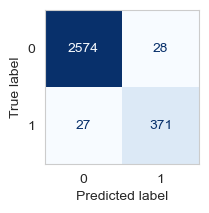

In [280]:
get_best_model(model_df2, 'adopted')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2602
           1       0.93      0.93      0.93       398

    accuracy                           0.98      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.98      0.98      0.98      3000



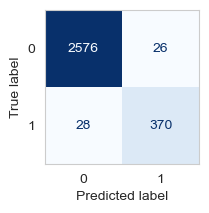

                               Feature  Importance
0                                usage    0.888830
1                               org_id    0.046612
2                        creation_time    0.036719
3             opted_in_to_mailing_list    0.004324
4    creation_source_PERSONAL_PROJECTS    0.003606
5                          email_gmail    0.002515
6         creation_source_GUEST_INVITE    0.002339
7           creation_source_ORG_INVITE    0.002265
8                        email_hotmail    0.002175
9               creation_source_SIGNUP    0.002011
10                         email_other    0.002001
11                         email_gustr    0.001922
12                         email_yahoo    0.001828
13                    email_jourrapide    0.001599
14  creation_source_SIGNUP_GOOGLE_AUTH    0.001254


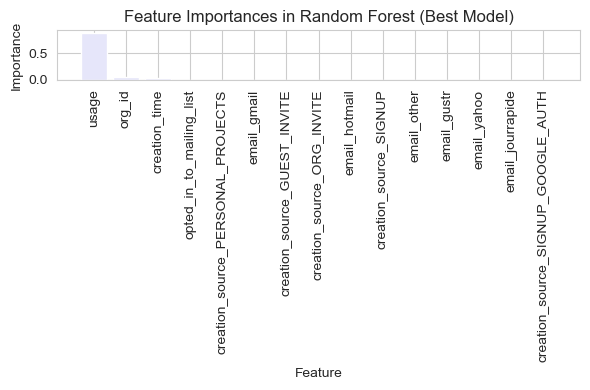

In [283]:
get_importance(model_df2, 'adopted')

In [289]:
# WHat if predicting without usage?
model_df3 = user_new[['email', 'creation_source', 'opted_in_to_mailing_list', 'creation_time', 'org_id', 'adopted']]

In [293]:
model_df3['adopted'] = model_df3['adopted'].replace({'Yes': 1, 'No': 0}) 
model_df3['adopted'] = model_df3['adopted'].astype('category')
model_df3 = get_dummy(model_df3, dummy_cols)

LogisticRegression Accuracy: 0.60
RandomForestClassifier Accuracy: 0.73
GaussianNB Accuracy: 0.57
 
Best model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2602
           1       0.18      0.29      0.22       398

    accuracy                           0.73      3000
   macro avg       0.53      0.54      0.53      3000
weighted avg       0.79      0.73      0.75      3000



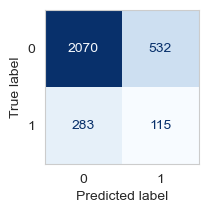

In [294]:
get_best_model(model_df3, 'adopted', oversampler = True)

In [296]:
model_df3_import = user_new[['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
                     'creation_time', 'adopted', 'org_id']]
model_df3_import['adopted'] = model_df3_import['adopted'].replace({'Yes': 1, 'No': 0}) 
model_df3_import['adopted'] = model_df3_import['adopted'].astype('category')
label_encoder = LabelEncoder()
object_cols = ['email', 'creation_source']
for object_col in object_cols:
    model_df3_import[object_col] = label_encoder.fit_transform(model_df3_import[object_col])

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2602
           1       0.17      0.06      0.09       398

    accuracy                           0.84      3000
   macro avg       0.52      0.51      0.50      3000
weighted avg       0.78      0.84      0.80      3000



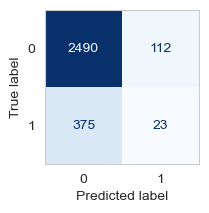

                      Feature  Importance
0                      org_id    0.565563
1               creation_time    0.273507
2                       email    0.070539
3             creation_source    0.052322
4    opted_in_to_mailing_list    0.020304
5  enabled_for_marketing_drip    0.017766


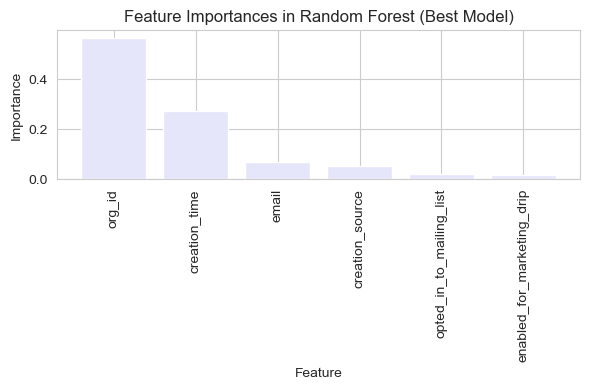

In [297]:
get_importance(model_df3_import, 'adopted')

Summary: 

Usage is the most important feature. The customer with higher usage are more likely to be adopted.

Without usage, org_id is an important feature. The customer attached with higher org_id are more likely to be adopted.

Creation time is also an important featuer. The account created at the earlier time are more likely to be adopted.